# ML Project: Diamond Quality
Eric López & Mustapha El Aichouni

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport
import src.utils as utils

In [2]:
df = pd.read_csv("data/diamonds.csv")

In [3]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [31]:
# profile_minimal = ProfileReport(df, minimal=True)
# profile_minimal.to_file("reports/diamonds_minimal_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

The minimal profiling report allows us to get a first impression of the whole dataset, while still not showing important statistics, as we haven't yet splitted into train and test set, and we are not interested in knowing about the test set.

We see that the dataset has no missing values, 3 categorical features and that the "Unnamed: 0" column corresponds to ids. We also get an idea of the type of values of each feature, so we can understand their meaning.

Now we do some basic preprocessing to handle these few problems we've seen, and separate into train and test set. Then we generate a more elaborated profiling report of the training data.

In [4]:
def basic_preprocessing(df: pd.DataFrame):
	df_copy = df.copy()

	# Encode categorical to numerical
	df_copy = utils.preprocessing_L(df_copy)

	# Split into X and y
	y = df_copy["cut"]
	X = df_copy.drop(columns=["cut", "Unnamed: 0"])

	# Split into train and test
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, y_train, y_test = basic_preprocessing(df)
X_train.head()

,carat,color,clarity,depth,table,price,x,y,z
26546,2.01,4,1,58.1,64.0,16231,8.23,8.19,4.77
9159,1.01,5,1,60.0,60.0,4540,6.57,6.49,3.92
14131,1.10,2,3,62.5,58.0,5729,6.59,6.54,4.10
15757,1.50,5,1,61.5,65.0,6300,7.21,7.17,4.42
24632,1.52,3,4,62.1,57.0,12968,7.27,7.32,4.53


In [6]:
# Generate the profiling report
# profile = ProfileReport(pd.concat([X_train, y_train], axis=1))

# Save the report as an HTML file
# profile.to_file("reports/diamonds_train_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

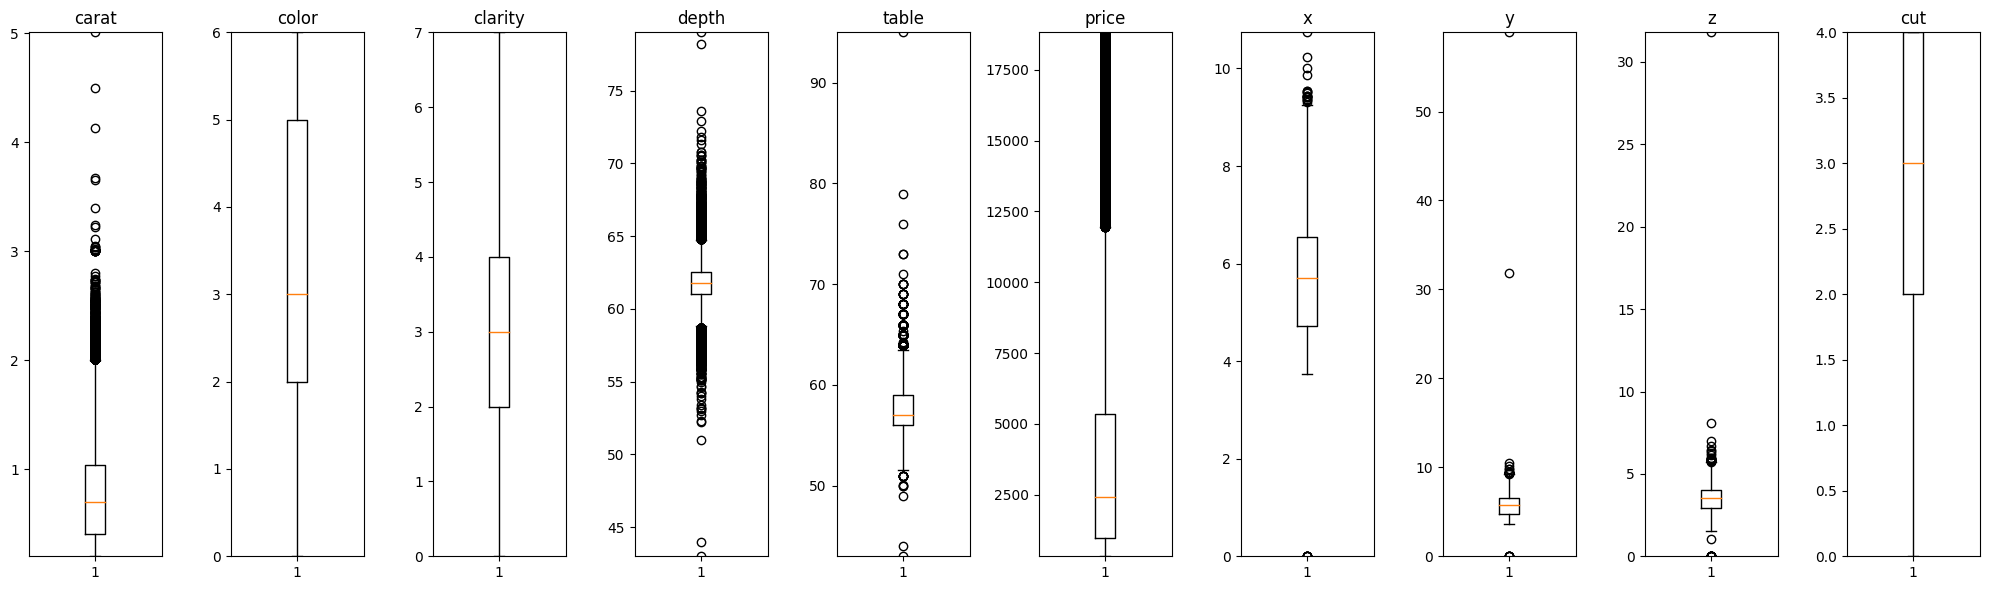

In [12]:
import matplotlib.pyplot as plt

df_train = pd.concat([X_train, y_train], axis=1)
features = df_train.columns
features_min = df_train.min()
features_max = df_train.max()

fig, axs = plt.subplots(1, len(features), figsize=(20, 6))

for i, feature in enumerate(features):
    axs[i].boxplot(df_train[feature])
    axs[i].set_ylim(features_min[feature], features_max[feature])
    axs[i].set_title(feature)

plt.tight_layout()

In [13]:
df_train_no_outliers = df_train.copy()

for feature in features:
	Q1 = df_train_no_outliers[feature].quantile(0.25)
	Q3 = df_train_no_outliers[feature].quantile(0.75)
	IQR = Q3 - Q1

	lower_bound = Q1 - 1.5 * IQR
	upper_bound = Q3 + 1.5 * IQR

	df_train_no_outliers = df_train_no_outliers[(df_train_no_outliers[feature] >= lower_bound) &
												(df_train_no_outliers[feature] <= upper_bound)]

<Figure size 2000x600 with 0 Axes>

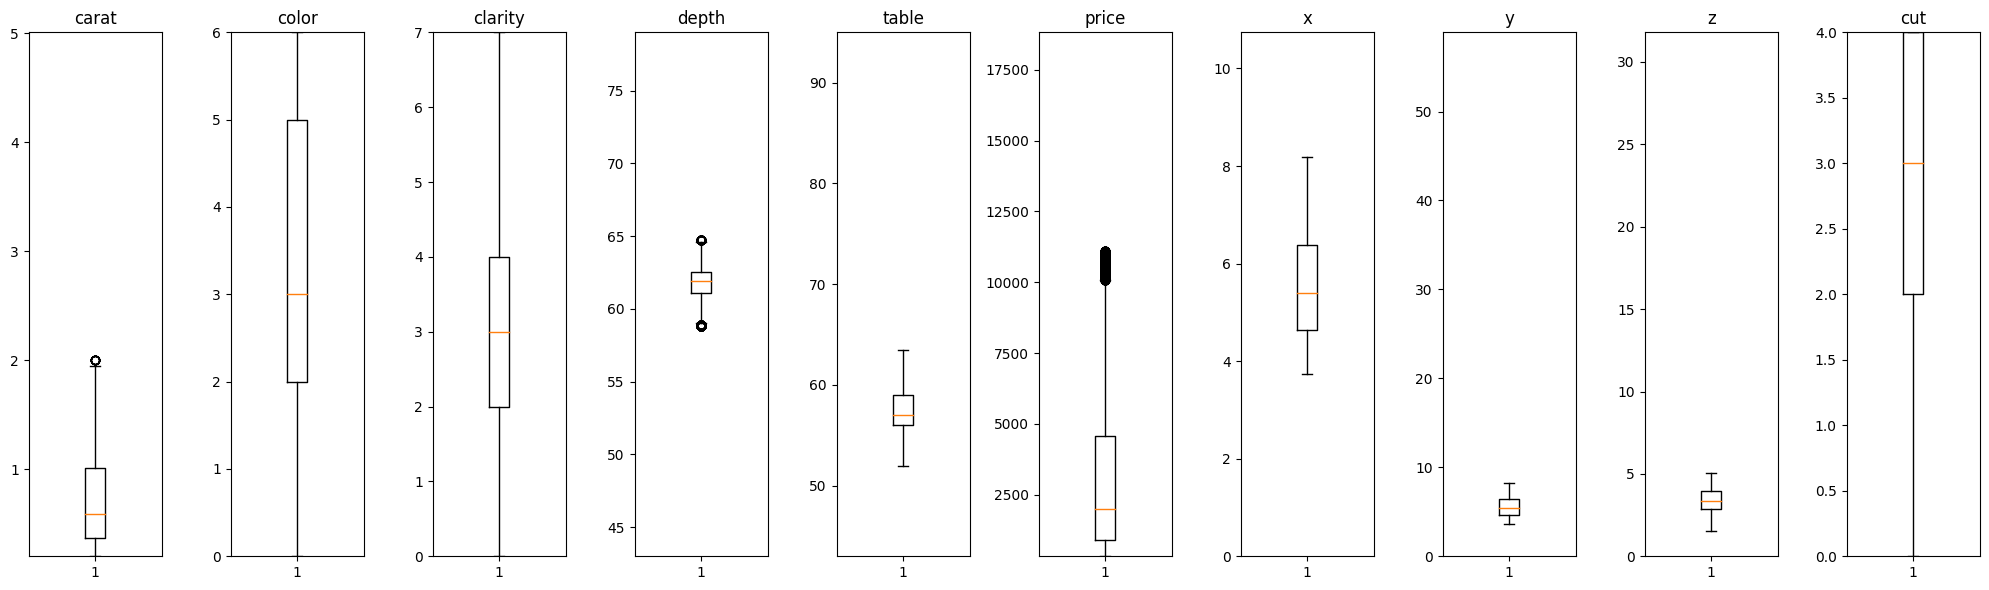

In [15]:
plt.figure(figsize=(20, 6))  # Adjust the size as needed

fig, axs = plt.subplots(1, len(features), figsize=(20, 6))

for i, feature in enumerate(features):
    axs[i].boxplot(df_train_no_outliers[feature])
    axs[i].set_ylim(features_min[feature], features_max[feature])
    axs[i].set_title(feature)

plt.tight_layout()

In [16]:
len(df_train) - len(df_train_no_outliers)

5583

---

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from src.logreg import LogReg
import src.utils as utils

In [2]:
df = pd.read_csv("data/diamonds.csv")
X, y, scaler = utils.preprocessing(df)
X.shape, y.shape

((48748, 5), (48748,))

In [3]:
model = LogReg(epsilon = .0001, random_state = 42, penalty = "l2", max_iter = 10000)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [5]:
model.cross_validation(X_train, y_train, n_splits = 5, val_size = 0.2)

Performing cross validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Cross validation (accuracy) scores:
	mean: 0.6383076923076924 std: 0.0018585764384020634


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.2s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.3s finished


In [6]:
model.fit(X_train, y_train)

LogReg()

In [7]:
X_test[:10]

,carat,color,clarity,depth,table
16238,1.206861,0.238555,-0.484264,-1.500344,1.137995
11170,0.953700,1.414272,-0.484264,-0.523105,1.137995
40562,-0.818426,0.238555,1.255295,-0.523105,1.585529
29579,-0.818426,-0.937163,-1.064117,0.733344,-0.204605
6907,0.215314,0.826413,0.095589,-0.174092,0.690462
21178,0.911506,-0.349304,0.675442,-0.383500,0.242928
38396,-0.860620,0.238555,0.095589,0.663542,0.242928
20180,1.692086,1.414272,-0.484264,-0.662711,0.242928
50509,-0.206621,1.414272,0.095589,1.850189,1.137995
20513,1.270151,0.826413,0.675442,0.803147,-1.099672


In [8]:
model.conf_matrix(X_test, y_test)

array([[   0,   44,    2,    4,    1],
       [   0,  375,  181,  126,   73],
       [   0,    8, 3901,  153,  214],
       [   0,    4,  406, 1483,  562],
       [   0,  204,  835,  650,  524]], dtype=int64)

---

Things to take into account in the future:

data structuring: categorical ->numerical

remove outilers

data normalization

split data into training and validation

train models

msouibgui@cvc.uab.cat

---